In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, _prepare_nice_labels
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

sns.set_style()

In [2]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print(mutspec.shape)
mutspec.head()

(187008, 10)


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


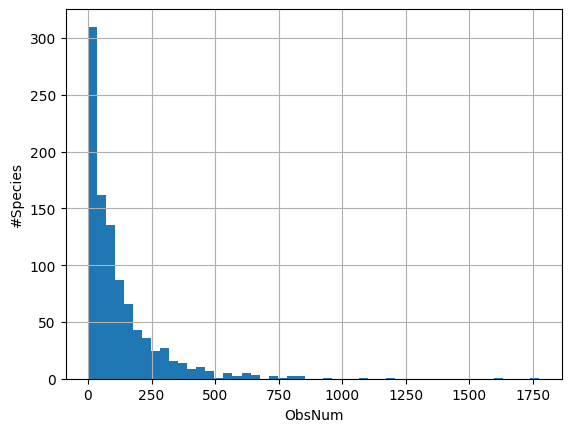

In [15]:
mutspec.groupby("Species").Observed.sum().hist(bins=50)
plt.xlabel("ObsNum")
plt.ylabel("#Species")
plt.show()

Assume that *Expected* and *Observed* values are correct

In [3]:
assert np.all(np.isclose((mutspec.Observed / mutspec.Expected).fillna(0).replace(np.inf, 0), mutspec.RawMutSpec)), "RawMutSpec is wrong"
assert np.all(np.isclose(mutspec.Species.map(mutspec.groupby("Species").RawMutSpec.sum().to_dict()), mutspec.RawMutSpecSum)), "RawMutSpecSum is wrong"
assert np.all(np.isclose((mutspec.RawMutSpec / mutspec.RawMutSpecSum), mutspec.MutSpec)), "MutSpec is wrong"

**Species mutspecs are correct**

### Let's caclulate aggregated mutspec for each class by 2 ways

In [10]:
# wrong method - imagine that all seqs in the class are one gene (concatenate and compute)

ms_cls1 = mutspec.groupby(["Class", "Mut"])[["Expected", "Observed"]].sum().reset_index()
ms_cls1["RawMutSpec"] = (ms_cls1["Observed"] / ms_cls1["Expected"]).fillna(0).replace(np.inf, 0)
ms_cls1["RawMutSpecSum"] = ms_cls1.Class.map(ms_cls1.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls1["MutSpec"] = (ms_cls1.RawMutSpec / ms_cls1.RawMutSpecSum)
print(ms_cls1.shape[0], ms_cls1.shape[0] / 192)
ms_cls1

960 5.0


,Class,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Actinopterygii,A[A>C]A,1195.0,30.0,0.025105,36.32104,0.000691
1,Actinopterygii,A[A>C]C,454.0,43.0,0.094714,36.32104,0.002608
2,Actinopterygii,A[A>C]G,1907.0,15.0,0.007866,36.32104,0.000217
3,Actinopterygii,A[A>C]T,0.0,0.0,0.000000,36.32104,0.000000
4,Actinopterygii,A[A>G]A,5528.0,1564.0,0.282923,36.32104,0.007790
...,...,...,...,...,...,...,...
955,Mammalia,T[T>C]T,2834.0,165.0,0.058222,54.70519,0.001064
956,Mammalia,T[T>G]A,3358.0,31.0,0.009232,54.70519,0.000169
957,Mammalia,T[T>G]C,1216.0,11.0,0.009046,54.70519,0.000165
958,Mammalia,T[T>G]G,4363.0,83.0,0.019024,54.70519,0.000348


In [9]:
# used method - compute Obs/Exp for each species and sum it for the class, after that - scale

ms_cls2 = mutspec.groupby(["Class", "Mut"])["RawMutSpec"].sum().reset_index()
ms_cls2["RawMutSpecSum"] = ms_cls2.Class.map(ms_cls2.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls2["MutSpec"] = (ms_cls2.RawMutSpec / ms_cls2.RawMutSpecSum)
print(ms_cls2.shape[0], ms_cls2.shape[0] / 192)
ms_cls2.head()

960 5.0


,Class,Mut,RawMutSpec,RawMutSpecSum,MutSpec
0,Actinopterygii,A[A>C]A,11.011111,12617.967436,0.000873
1,Actinopterygii,A[A>C]C,18.283333,12617.967436,0.001449
2,Actinopterygii,A[A>C]G,2.692857,12617.967436,0.000213
3,Actinopterygii,A[A>C]T,0.000000,12617.967436,0.000000
4,Actinopterygii,A[A>G]A,135.017108,12617.967436,0.010700


### Plot 192-spectra

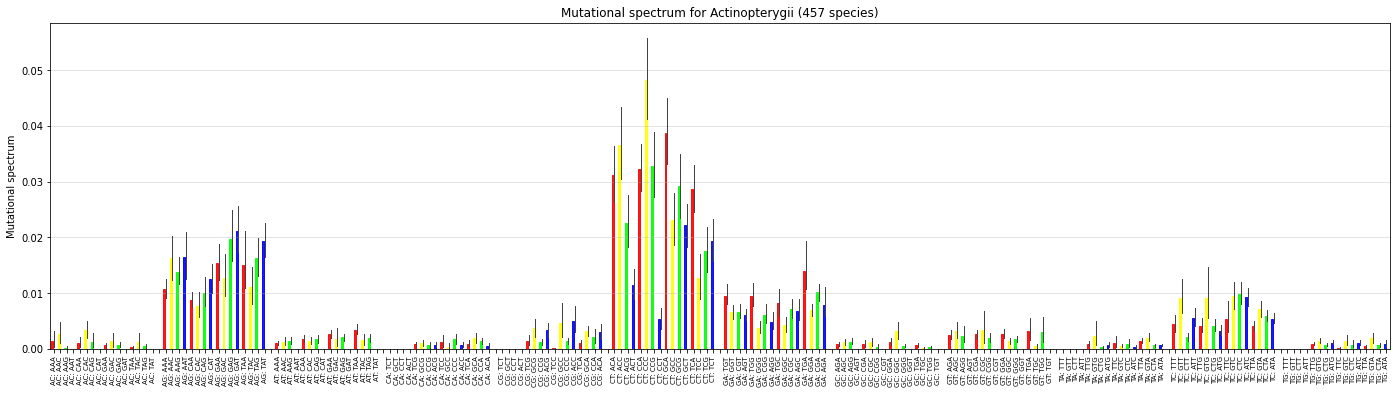

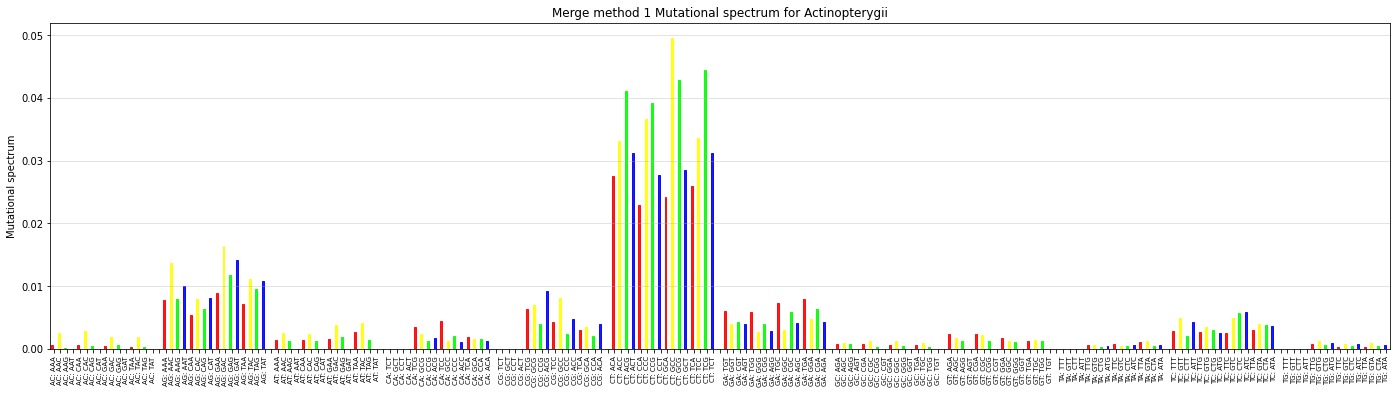

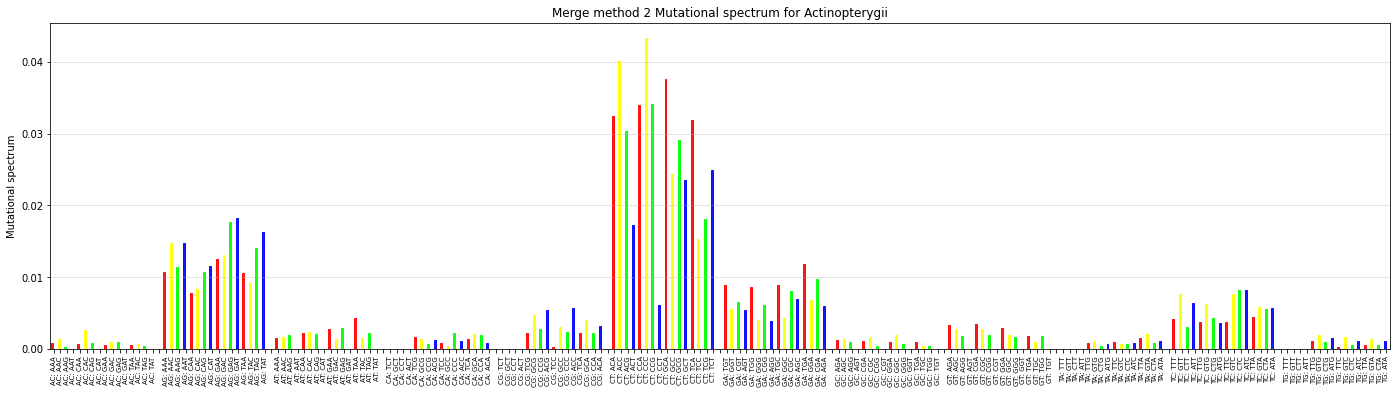

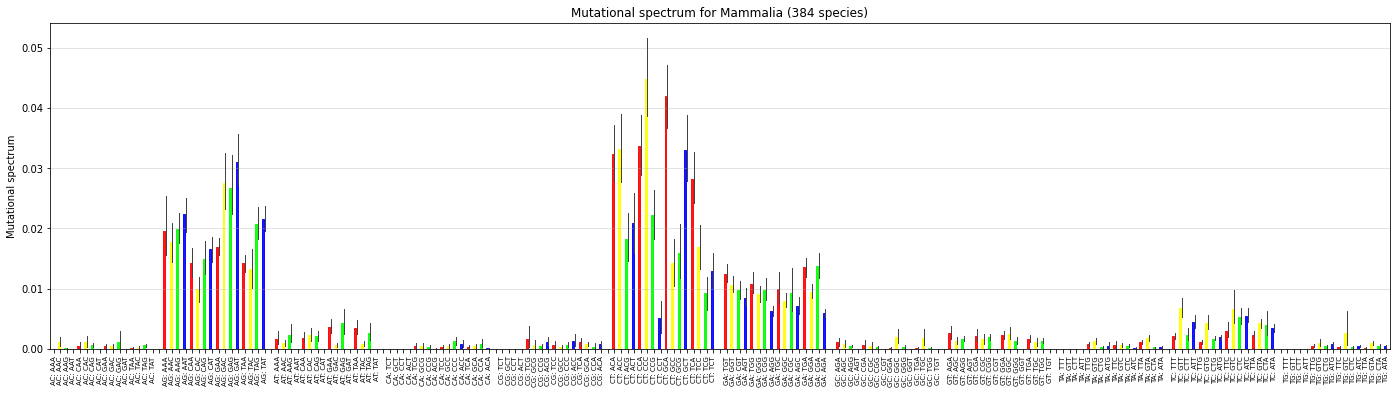

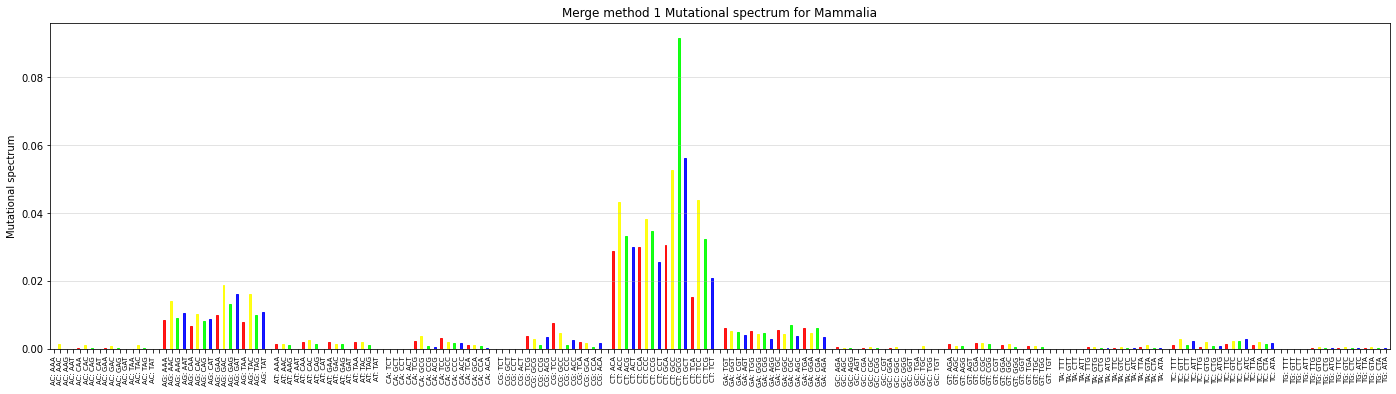

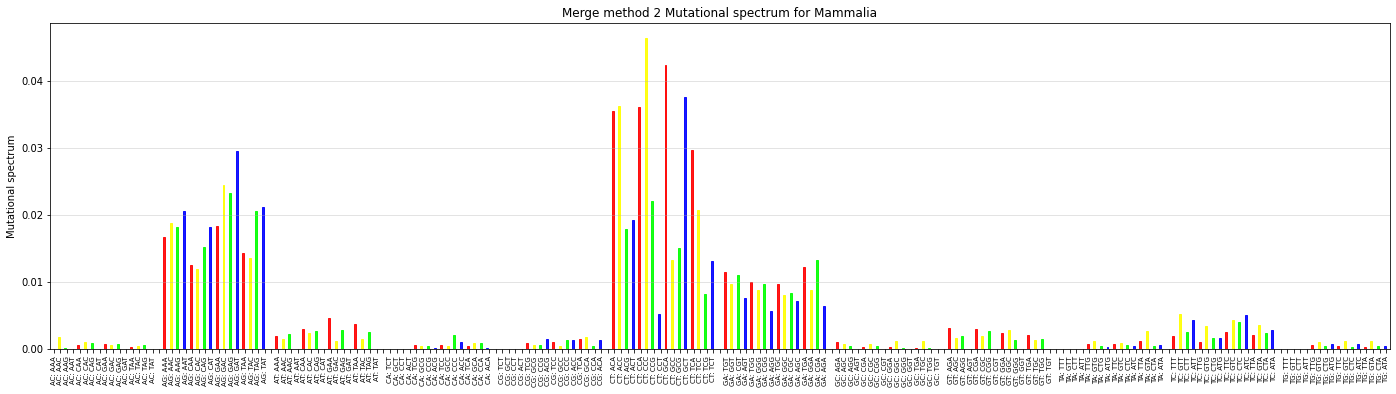

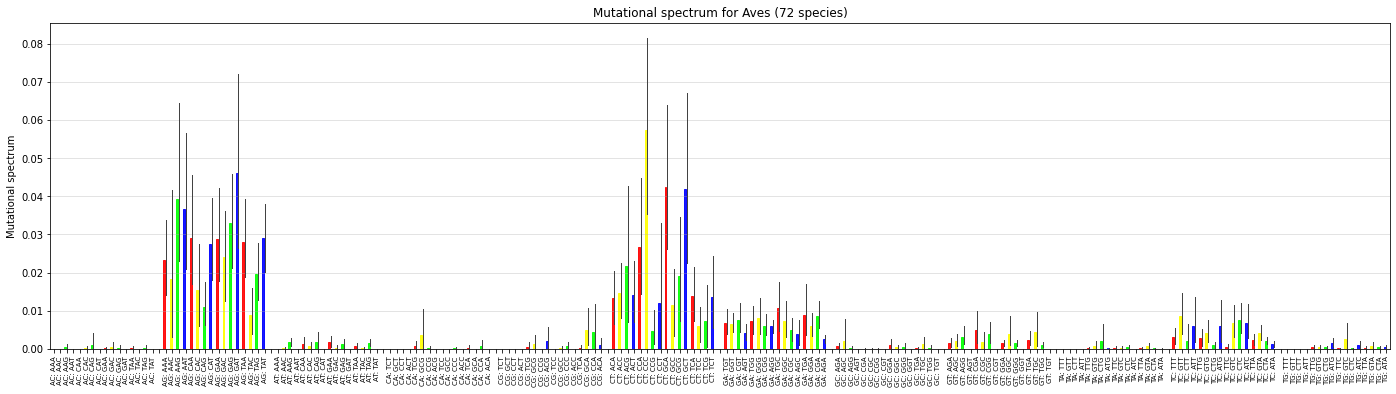

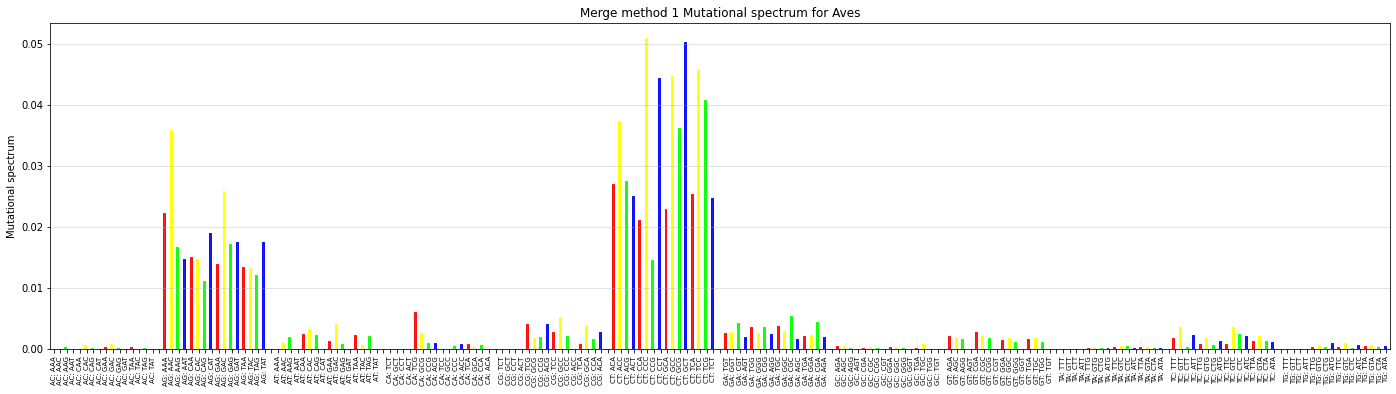

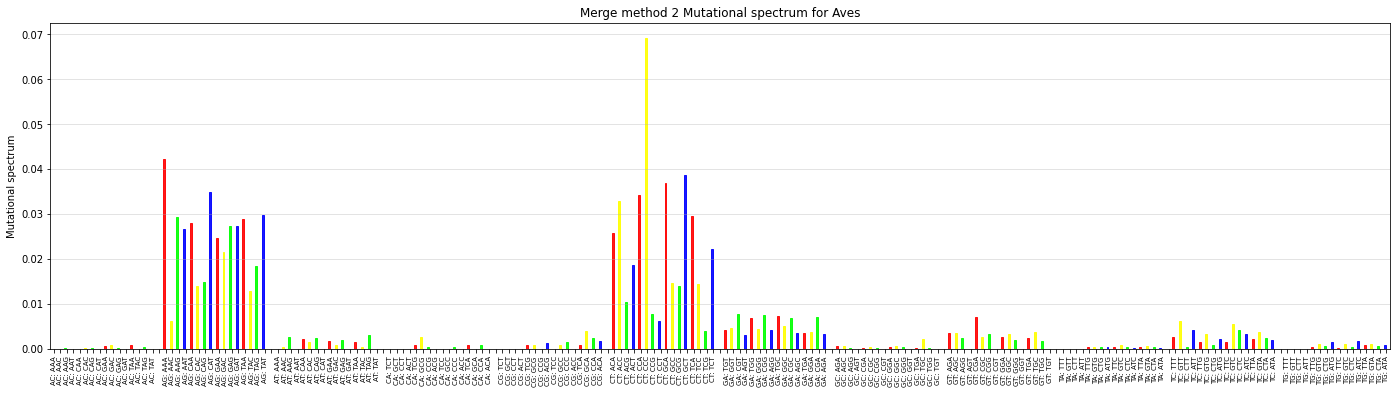

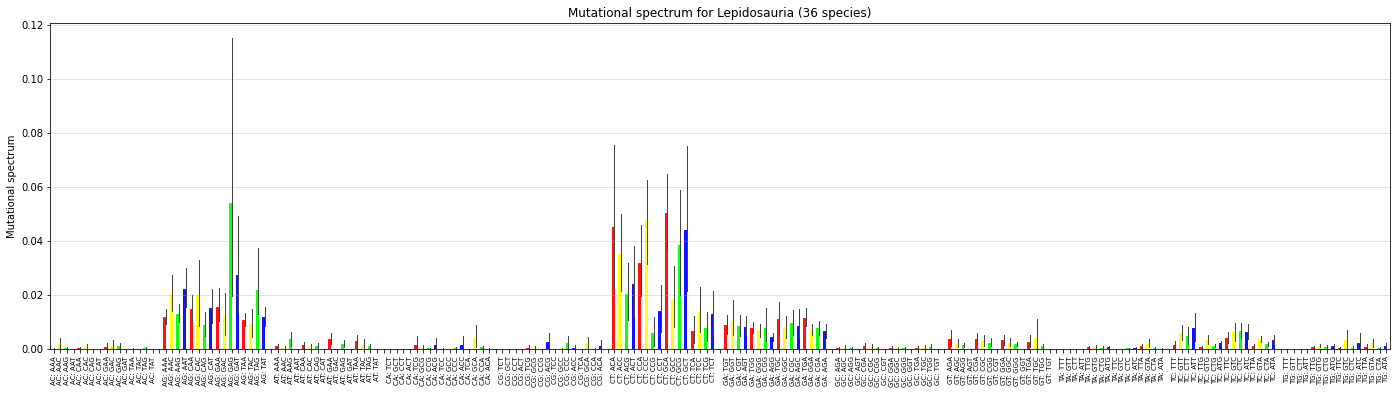

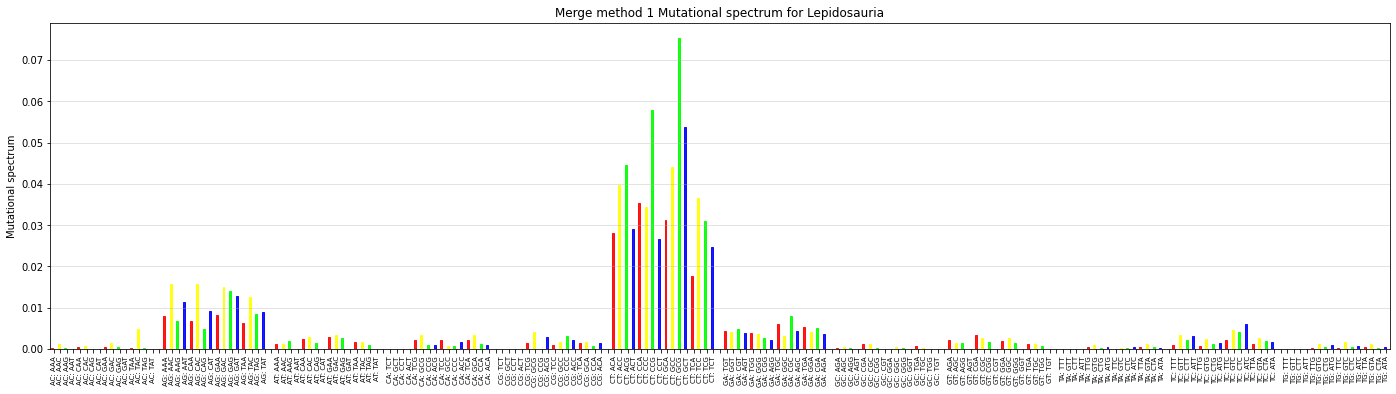

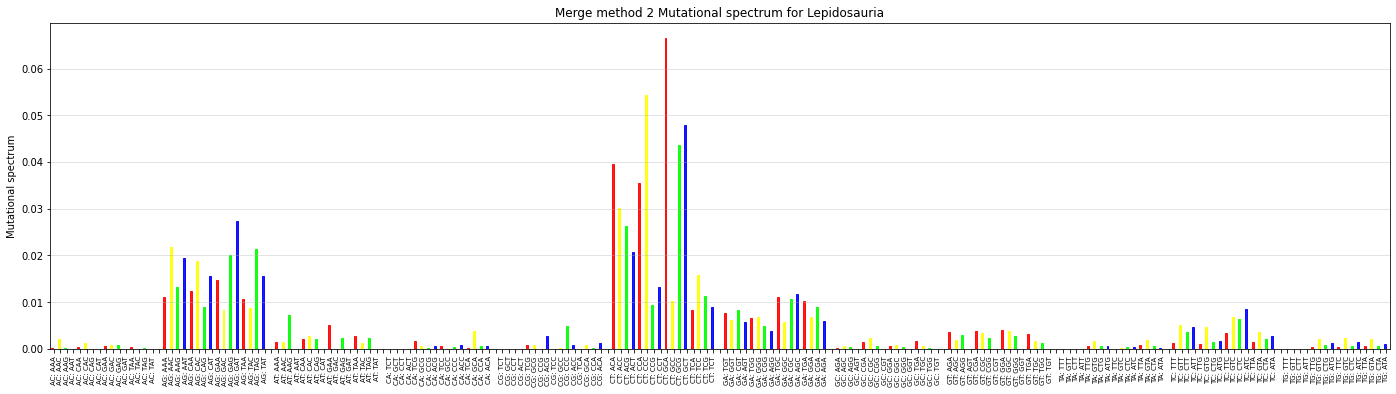

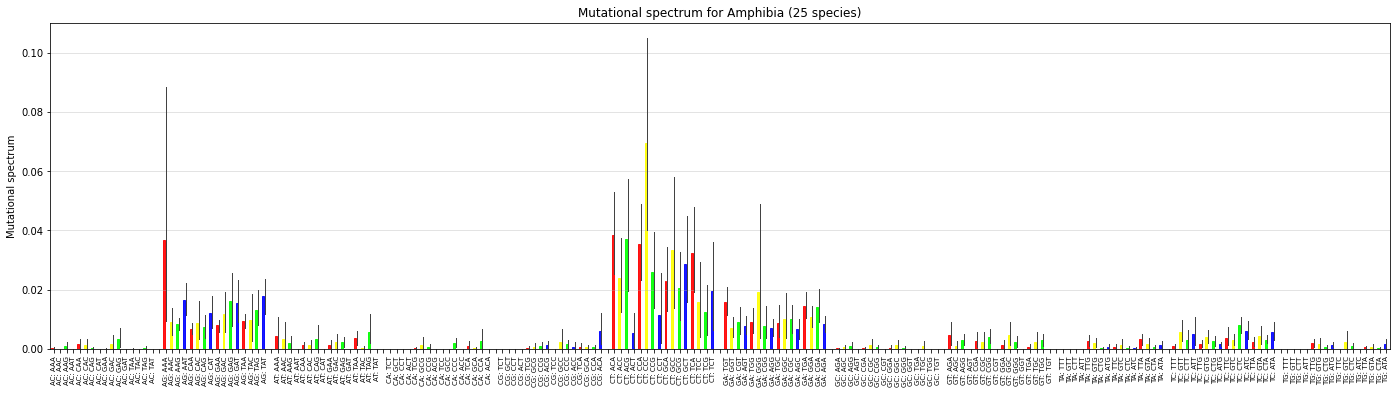

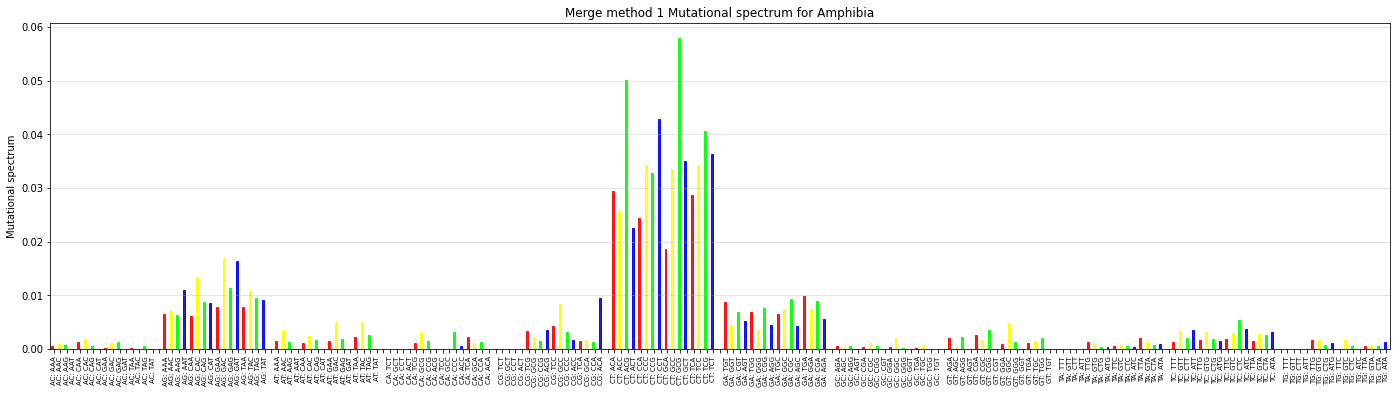

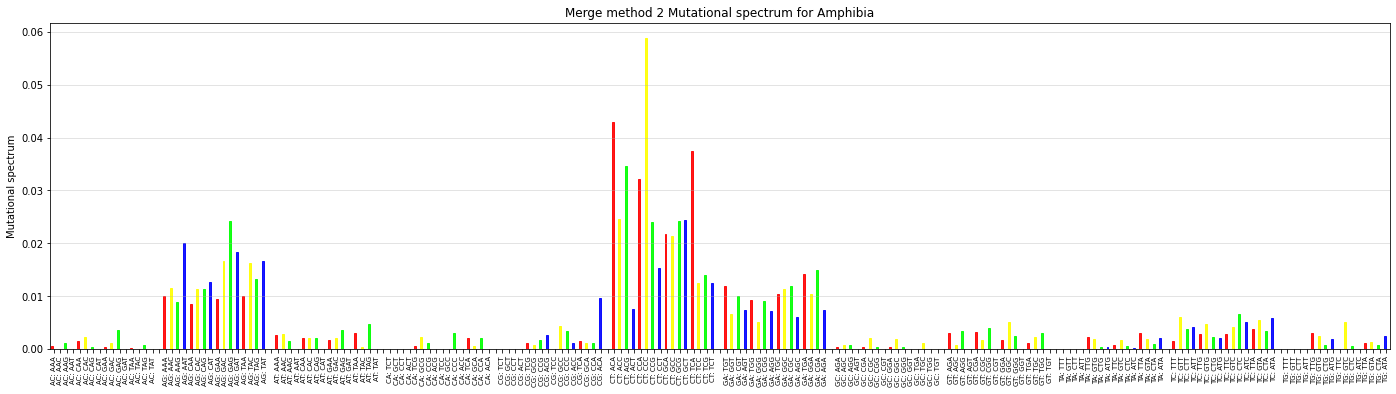

In [73]:
for cls in mutspec.Class.unique():
    ns = mutspec[mutspec.Class == cls].Species.nunique()
    plot_mutspec192kk(mutspec[mutspec.Class == cls], title=f"Mutational spectrum for {cls} ({ns} species)")
    plot_mutspec192kk(ms_cls1[ms_cls1.Class == cls], title=f"Merge method 1 Mutational spectrum for {cls}")
    plot_mutspec192kk(ms_cls2[ms_cls2.Class == cls], title=f"Merge method 2 Mutational spectrum for {cls}")

## Check with primitive meaning and 2 methods

In [85]:
for cls in mutspec.Class.unique():
    ms_mean = mutspec[mutspec.Class == cls].groupby("Mut").MutSpec.mean().sort_index()
    ms_correct = ms_cls1[ms_cls1.Class == cls].set_index("Mut").MutSpec.sort_index()
    sim = 1 - spatial.distance.cosine(ms_mean.values, ms_correct.values)
    print(f"Class: {cls}, sim = {sim:.2f}")

Class: Actinopterygii, sim = 0.88
Class: Mammalia, sim = 0.77
Class: Aves, sim = 0.78
Class: Lepidosauria, sim = 0.80
Class: Amphibia, sim = 0.83


In [86]:
for cls in mutspec.Class.unique():
    ms_mean = mutspec[mutspec.Class == cls].groupby("Mut").MutSpec.mean().sort_index()
    ms_correct = ms_cls2[ms_cls2.Class == cls].set_index("Mut").MutSpec.sort_index()
    sim = 1 - spatial.distance.cosine(ms_mean.values, ms_correct.values)
    print(f"Class: {cls}, sim = {sim:.2f}")

Class: Actinopterygii, sim = 0.99
Class: Mammalia, sim = 1.00
Class: Aves, sim = 0.94
Class: Lepidosauria, sim = 0.96
Class: Amphibia, sim = 0.96


## substitutions distributions

In [3]:
mutspec

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
187003,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves
187004,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves
187005,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves
187006,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves


In [4]:
mutspec["Context_outer"] = mutspec["Context"].str.slice(0, 3, 2)

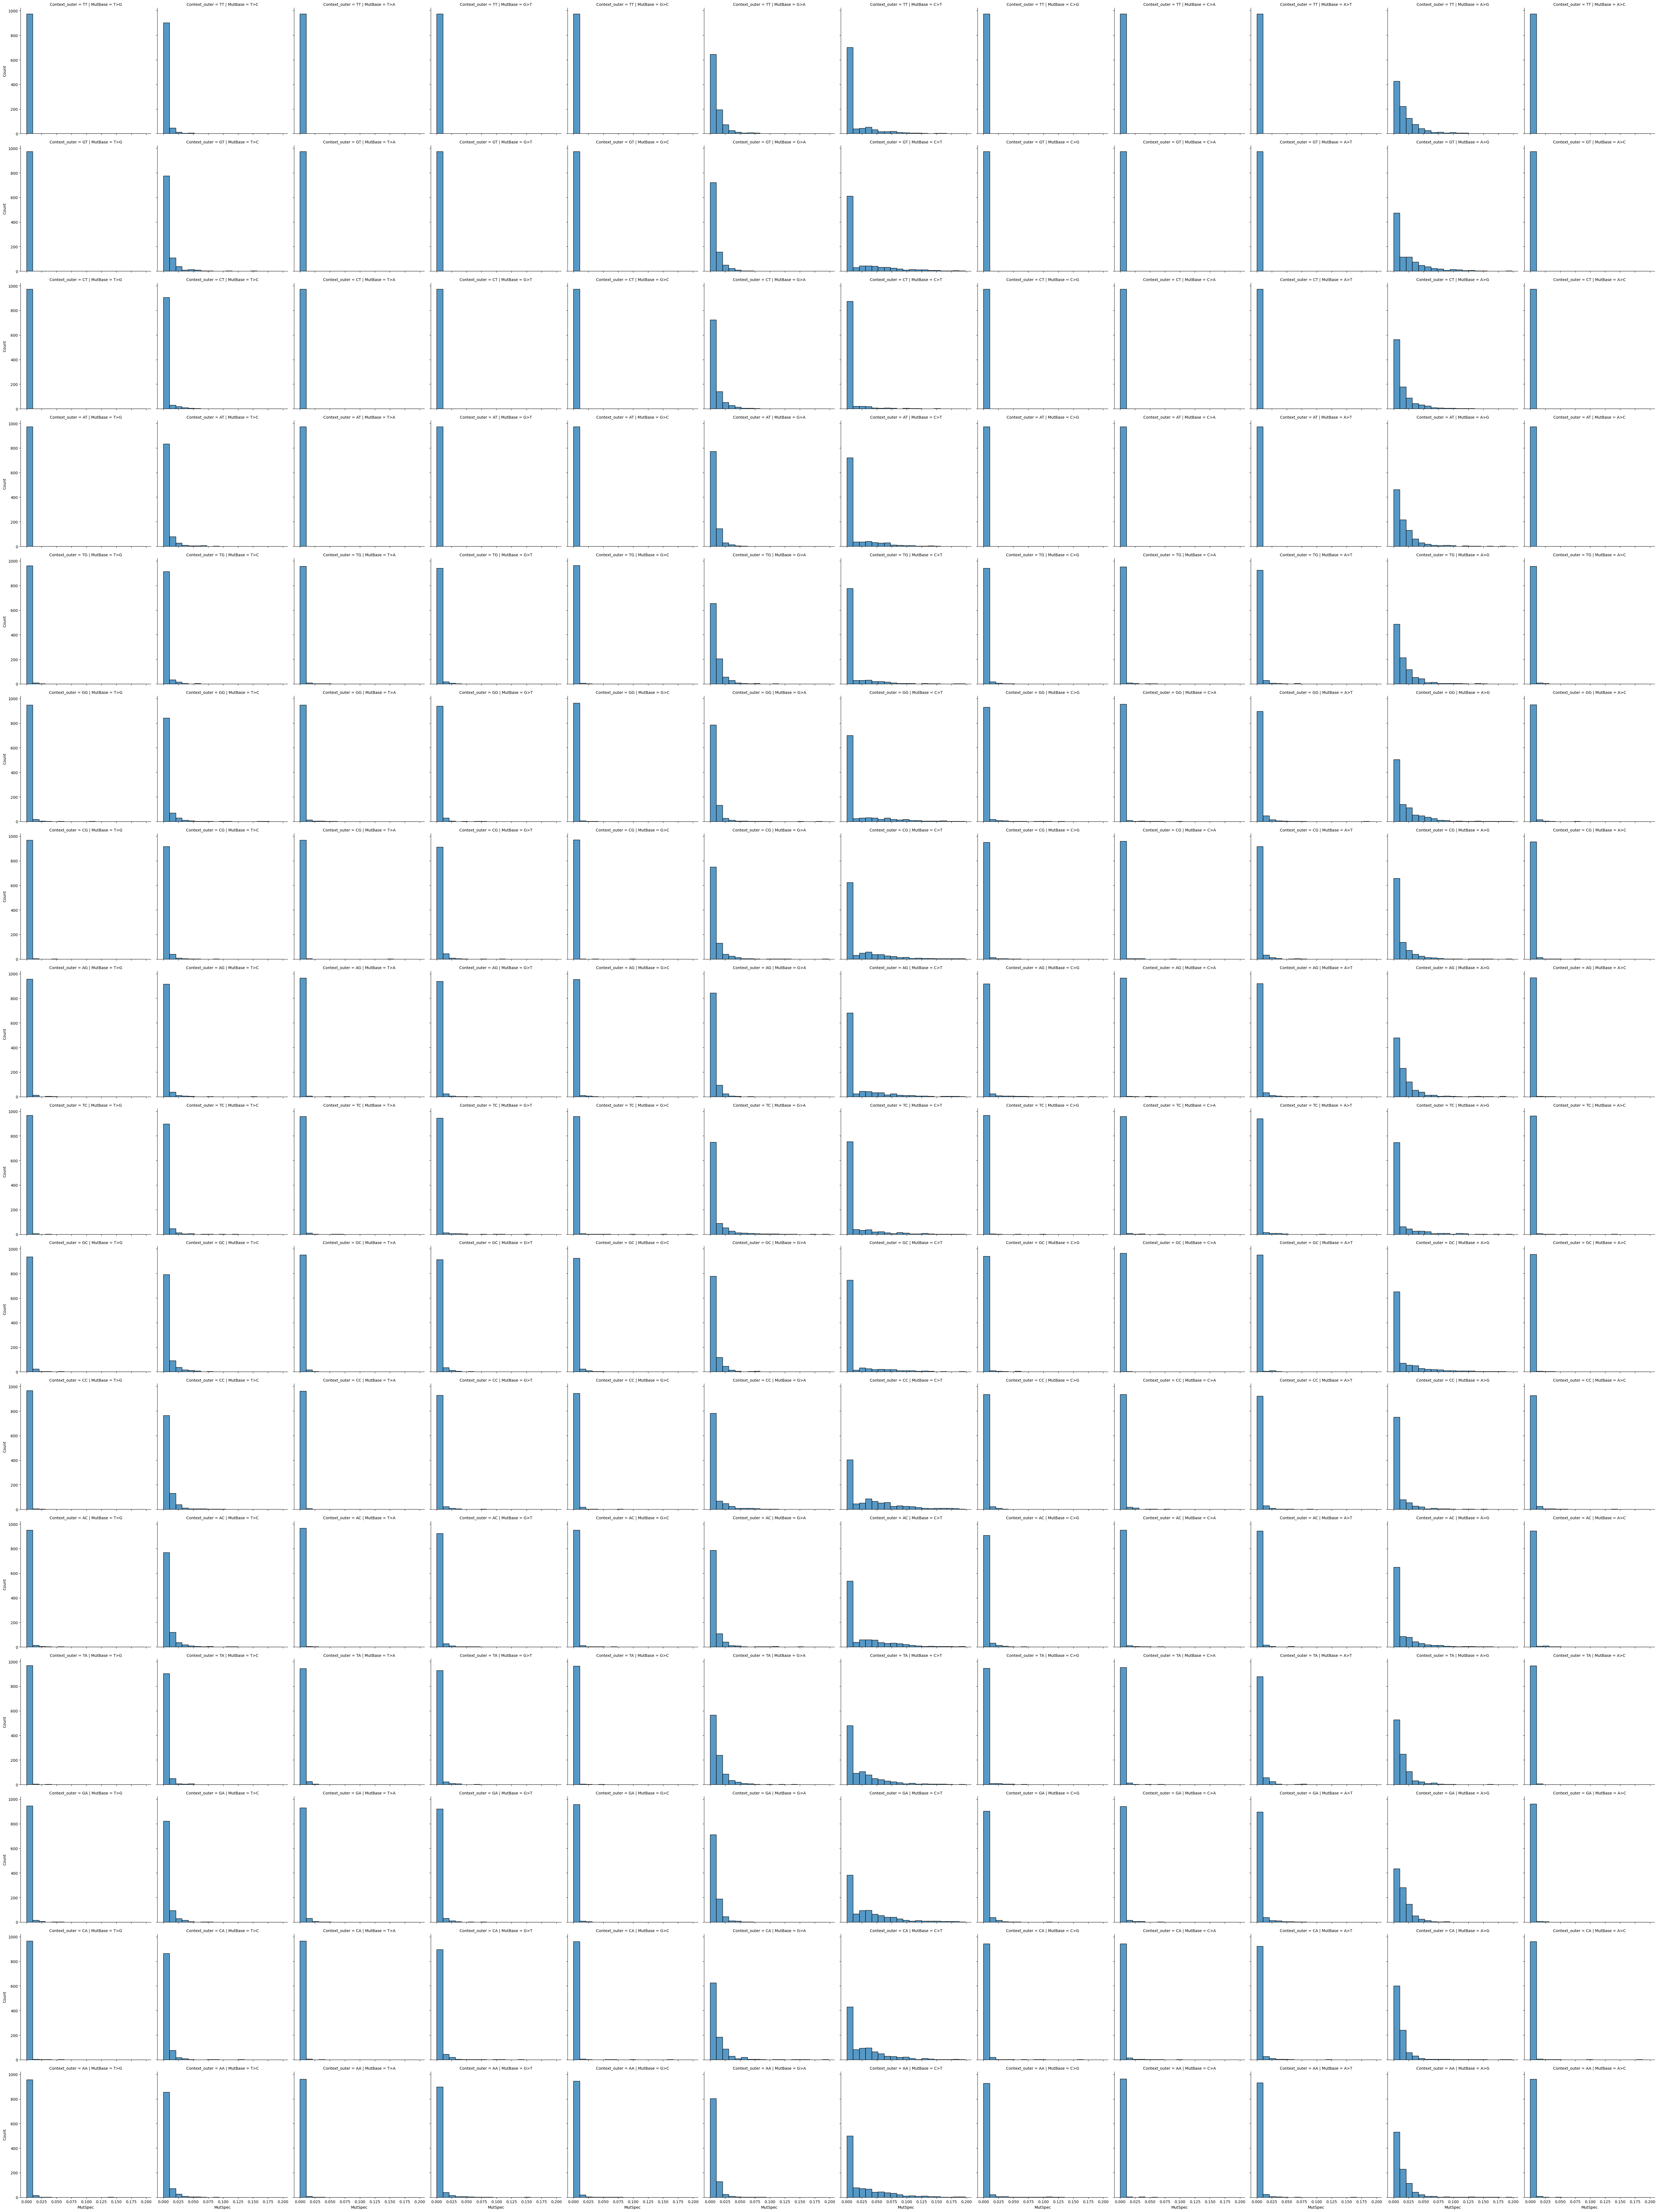

In [9]:
sns.displot(mutspec[mutspec.MutSpec < 0.2], x="MutSpec", row="Context_outer", col="MutBase")

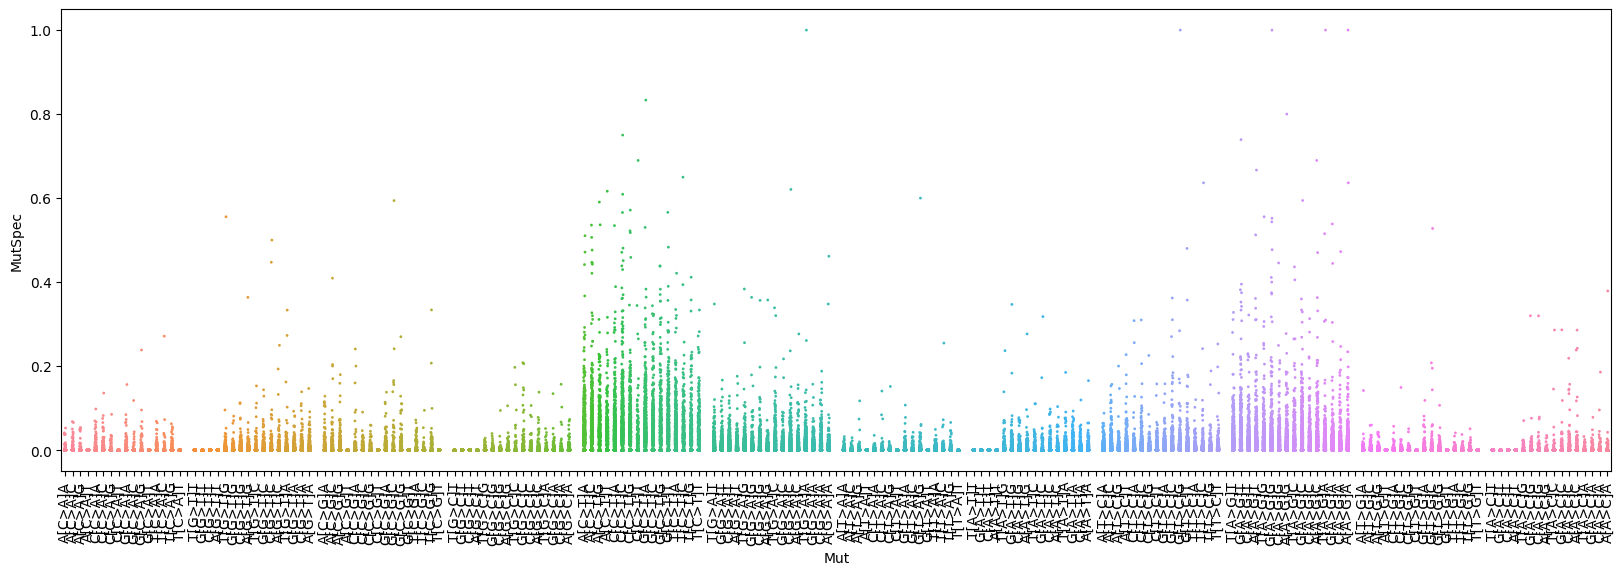

In [4]:
plt.figure(figsize=(20, 6))
sns.stripplot(data=mutspec, x="Mut", y="MutSpec", order=_prepare_nice_labels(ordered_sbs192_kp), size=2)
plt.xticks(rotation=90, )
plt.show()